##### 1.匯入套件

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

from scipy.stats import zscore
import statsmodels.api as sm

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    auc as sk_auc, recall_score, precision_score, fbeta_score
)
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer

from imblearn.over_sampling import SMOTENC
from category_encoders import TargetEncoder

In [4]:
# === 匯入圖表儲存函數 ===
def save_plot(fig, filename, model_name='rf_halving'):
    """
    儲存圖表到 ../results/{model_name}/{filename}
    """
    path = f'../results/{model_name}'
    os.makedirs(path, exist_ok=True)
    fig.savefig(f'{path}/{filename}', dpi=300)


##### 2.讀取資料與切割訓練、驗證與測試集

In [5]:
df = pd.read_csv('../raw_data/train_2025.csv')
X = df.drop(columns=['claim_number', 'fraud'])
y = df['fraud']

# 60% 訓練、20% 驗證、20% 測試
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

##### 3. 資料清洗與預處理

In [6]:
# 以下特徵工程跟logit一樣，可省略不看
mask = ~X_train['zip_code'].astype(str).str.startswith('0')
X_train = X_train[mask].reset_index(drop=True)
y_train = y_train[mask].reset_index(drop=True)

cat_cols = [
    'gender', 'marital_status', 'high_education_ind', 'address_change_ind',
    'living_status', 'zip_code', 'claim_date', 'claim_day_of_week', 'accident_site',
    'witness_present_ind', 'channel', 'policy_report_filed_ind', 'vehicle_category', 'vehicle_color'
]
num_cols = [col for col in X_train.columns if col not in cat_cols]

##### 4. 建立特徵轉換器（自定義）

In [7]:
def encode_gender(X): return (X == 'M').astype(int)
def encode_living_status(X): return (X == 'Own').astype(int)

# class Zip3Extractor(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None): self.feature_names_in_ = list(X.columns); return self
#     def transform(self, X): return pd.DataFrame(X, columns=self.feature_names_in_).apply(lambda col: col.astype(str).str[:3])
#     def get_feature_names_out(self, input_features=None): return [f"{feat}_zip3" for feat in (input_features or ['zip3'])]

# class ExtractMonthYear(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None): self.feature_names_in_ = list(X.columns); return self
#     def transform(self, X): return pd.to_datetime(X.iloc[:, 0], errors='coerce').dt.to_period('M').astype(str).to_frame()
#     def get_feature_names_out(self, input_features=None): return [f"{feat}_month_year" for feat in (input_features or ['claim_date'])]

class Zip3Extractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names_in_ = (
            list(X.columns) if hasattr(X, 'columns') else [f'x{i}' for i in range(X.shape[1])]
        )
        return self

    def transform(self, X):
        df = pd.DataFrame(X, columns=self.feature_names_in_)
        return df.apply(lambda col: col.astype(str).str[:3])

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return [f"{feat}_zip3" for feat in input_features]
    
class ExtractMonthYear(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names_in_ = (
            list(X.columns) if hasattr(X, 'columns') else [f'x{i}' for i in range(X.shape[1])]
        )
        return self

    def transform(self, X):
        s = pd.Series(X[:, 0]) if isinstance(X, np.ndarray) else X.iloc[:, 0]
        date = pd.to_datetime(s, errors='coerce')
        return date.dt.to_period('M').astype(str).to_frame()

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return [f"{feat}_month_year" for feat in input_features]


class TargetEncoderWrapper(TargetEncoder):
    def get_feature_names_out(self, input_features=None): return input_features if input_features is not None else self.feature_names_in_

##### 5. 預處理流程建構

In [8]:
marital_witness_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent'))])
gender_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('label_encoder', FunctionTransformer(encode_gender, validate=False, feature_names_out='one-to-one'))
])
living_status_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('label_encoder', FunctionTransformer(encode_living_status, validate=False, feature_names_out='one-to-one'))
])
zip3_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('zip3_extract', Zip3Extractor()),
    ('target', TargetEncoderWrapper())
])
claim_date_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('extract_month_year', ExtractMonthYear()),
    ('target', TargetEncoderWrapper())
])
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])
target_cat_cols = ['claim_day_of_week', 'accident_site', 'channel', 'vehicle_category', 'vehicle_color']
target_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target', TargetEncoderWrapper())
])

# ===  整合所有欄位轉換 ===
transformers = [
    ('marital_witness', marital_witness_pipeline, ['marital_status', 'witness_present_ind']),
    ('gender', gender_pipeline, ['gender']),
    ('living_status', living_status_pipeline, ['living_status']),
    ('zip_code', zip3_pipeline, ['zip_code']),
    ('claim_date', claim_date_pipeline, ['claim_date']),
    ('num', num_pipeline, num_cols),
    ('cat_imputer', target_cat_pipeline, target_cat_cols)
]
preprocessor = ColumnTransformer(transformers, remainder='passthrough')


##### 6.設定 Halving Grid Search

In [9]:
# 超參數設置
param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [None, 10],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 4],
    "max_features": ["sqrt"],
    "class_weight": [None, "balanced"]
}
grid = list(ParameterGrid(param_grid))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 設定 halving 的參數
max_iter = 6  # 幾輪 Halving
factor = 2    # 每輪保留幾分之幾（例如 factor=2 表示每輪保留 50%）
initial_frac = 1/32  # 初始訓練資料比例
results = []    # 產生參數組合的 dict 清單
current_candidates = grid.copy()

##### 7.Halving 交叉驗證訓練

In [10]:
# 計時開始
start_time = time.time()
for iteration in range(max_iter):
    print(f"\n=== Halving Iteration {iteration}/{max_iter} ===")

    # 每一輪訓練資料增加
    frac = min(initial_frac * (factor ** iteration), 1.0)
    n_samples = int(len(X_train) * frac)
    scores = []

    for param in current_candidates:
        aucs = []
        for train_idx, val_idx in skf.split(X_train, y_train):
            # 依照當前比例選前 n_samples
            X_tr_f = X_train.iloc[train_idx][:n_samples].copy()
            y_tr_f = y_train.iloc[train_idx][:n_samples].copy()
            X_val_f = X_train.iloc[val_idx].copy()
            y_val_f = y_train.iloc[val_idx].copy()

            # Z-score 移除離群值
            z_scores = X_tr_f[num_cols].apply(zscore)
            mask_no_outliers = (z_scores.abs() < 3).all(axis=1)
            X_tr_f = X_tr_f.loc[mask_no_outliers].reset_index(drop=True)
            y_tr_f = y_tr_f.loc[mask_no_outliers].reset_index(drop=True)

            # 特徵工程
            X_tr_transformed = preprocessor.fit_transform(X_tr_f, y_tr_f)
            X_val_transformed = preprocessor.transform(X_val_f)

            # SMOTENC
            feature_names = preprocessor.get_feature_names_out()
            cat_indices = [i for i, col in enumerate(feature_names) if col.startswith(('gender__', 'living_status__', 'zip_code__', 'claim_date__', 'cat_imputer__', 'remainder__'))]
            smote_nc = SMOTENC(categorical_features=cat_indices, random_state=42)
            X_resampled, y_resampled = smote_nc.fit_resample(X_tr_transformed, y_tr_f)

            # 模型訓練
            model = RandomForestClassifier(**param, random_state=42)
            model.fit(X_resampled, y_resampled)

            # 驗證 AUC
            y_pred_proba = model.predict_proba(X_val_transformed)[:, 1]
            auc = roc_auc_score(y_val_f, y_pred_proba)
            aucs.append(auc)

        mean_auc = np.mean(aucs)
        scores.append((param, mean_auc))
        print(f"Param: {param} | AUC: {mean_auc:.4f}")

    # 只在最後一輪時記錄結果
    if iteration == max_iter - 1:
        results = scores.copy()  # 只保留最後一輪的參數組合與分數
    
    # 保留 top k 進入下一輪
    scores.sort(key=lambda x: x[1], reverse=True)
    keep_top_k = max(1, len(scores) // factor)
    current_candidates = [param for param, _ in scores[:keep_top_k]]

print("\n=== Final Top Params ===")
for param, auc in sorted(results, key=lambda x: x[1], reverse=True)[:5]:
    print(f"{param} | AUC: {auc:.4f}")

end_time = time.time()
print(f"執行時間: {end_time - start_time:.2f} 秒")

#  找出最佳組合
best_param, best_score = max(results, key=lambda x: x[1])
print("\n最佳超參數:", best_param)
print("平均 ROC-AUC:", best_score)

# 訓練最終模型
final_rf = RandomForestClassifier(random_state=42, n_jobs=-1, **best_param)
final_rf.fit(X_resampled, y_resampled)



=== Halving Iteration 0/6 ===
Param: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} | AUC: 0.5920
Param: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300} | AUC: 0.5937
Param: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100} | AUC: 0.5879
Param: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300} | AUC: 0.5912
Param: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100} | AUC: 0.5954
Param: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300} | AUC: 0.5968
Param: {'class_weight': None, 'max_de

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=300, n_jobs=-1, random_state=42)

##### 8.驗證集選閾值並測試集評估

In [11]:
X_valid_transformed = preprocessor.transform(X_valid)
y_proba = final_rf.predict_proba(X_valid_transformed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, y_proba)
roc_auc = sk_auc(fpr, tpr)

# 以 Recall 下限 尋找最佳閾值
target_recall = 0.8
best_threshold = 0
best_prec = 0
for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    recall = recall_score(y_valid, y_pred_thresh)
    precision = precision_score(y_valid, y_pred_thresh)
    if recall >= target_recall and precision > best_prec:
        best_prec = precision
        best_threshold = threshold

print(f'最佳 Recall 下界時的閾值：{best_threshold:.4f}')


d:\users\anaconda\envs\Fraud_Detection\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


最佳 Recall 下界時的閾值：0.3137


##### 9.測試集評估與特徵重要性視覺化

測試集績效報告：
              precision    recall  f1-score   support

           0       0.92      0.42      0.58      3031
           1       0.21      0.81      0.33       569

    accuracy                           0.48      3600
   macro avg       0.56      0.62      0.45      3600
weighted avg       0.81      0.48      0.54      3600

auc: 0.6693
f2-score: 0.5124


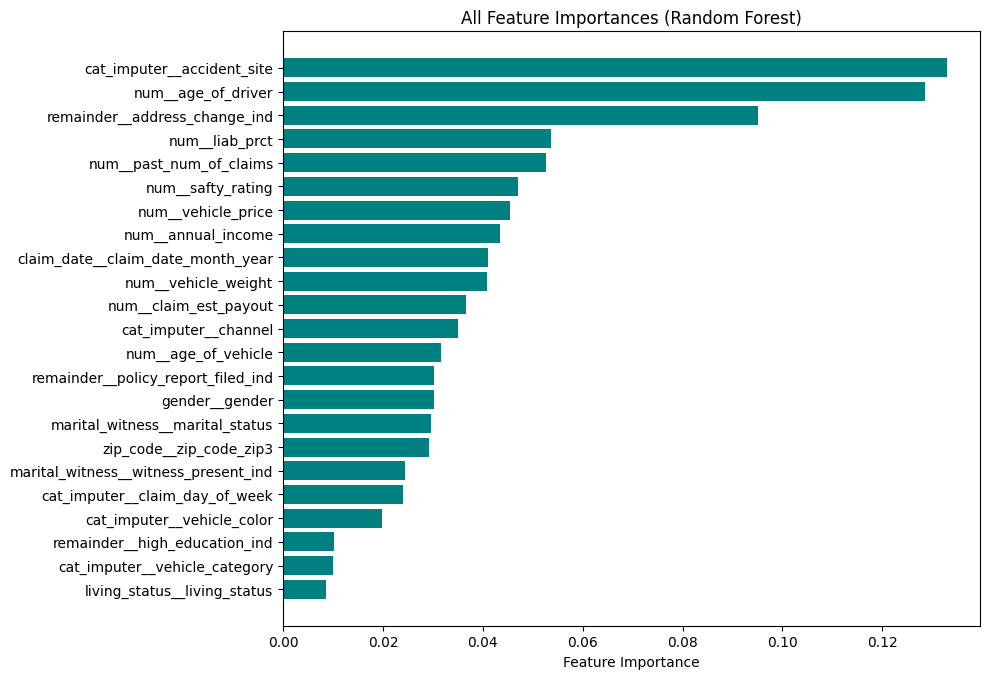

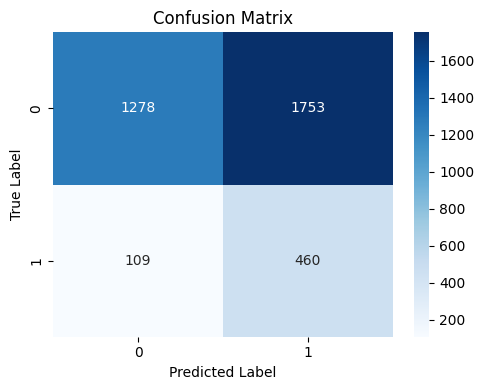

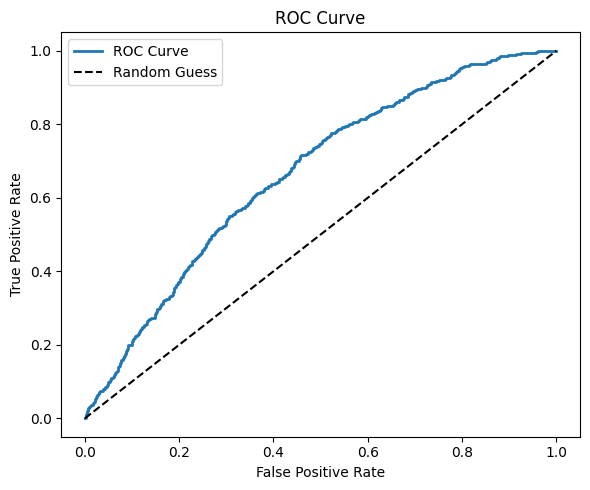

In [12]:
# === 預測與績效評估 ===
X_test_transformed = preprocessor.transform(X_test)
y_test_proba = final_rf.predict_proba(X_test_transformed)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

print("測試集績效報告：")
print(classification_report(y_test, y_test_pred))
print(f'auc: {roc_auc:.04f}')
print(f'f2-score: {fbeta_score(y_test, y_test_pred, beta=2):.04f}')

# === 特徵重要性分析 ===
importances = final_rf.feature_importances_
feature_names = preprocessor.get_feature_names_out()

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

fig = plt.figure(figsize=(10, len(feat_imp) * 0.3))
plt.barh(feat_imp['feature'][::-1], feat_imp['importance'][::-1], color='teal')
plt.xlabel("Feature Importance")
plt.title("All Feature Importances (Random Forest)")
plt.tight_layout()
save_plot(fig, "feature_importance.png", model_name='rf_halving')
plt.show()

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

# === 混淆矩陣圖 ===
conf_matrix = confusion_matrix(y_test, y_test_pred)
fig_cm = plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
save_plot(fig_cm, "confusion_matrix.png", model_name='rf_halving')
plt.show()

# === ROC 曲線圖 ===
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
fig_roc = plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
save_plot(fig_roc, "roc_curve.png", model_name='rf_halving')
plt.show()
